In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [7]:
rolling_window = 10
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            for member in Indicator:
                price = member.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11261/11261 [02:43<00:00, 68.96it/s]


In [8]:
model_end = 2020
backtest_end = 2026
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [9]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                                            ranking_metrics=["sma_corr","sma"]
                                                            ,num_of_groups=[3]
                                                            ,group_percentages=[1]
                                                            ,max_prices=[3]
                                                            ,min_prices=[1]
                                                            ,stoplosses=[0.05]
                                                            ,rolling_windows=[rolling_window]
                                                            )
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "day"  and portfolio.selection_type.label == "top_blacklist" \
            and portfolio.position_type.label == "long" and portfolio.allocation_type.label == "equal":
            filtered_portfolios.append(portfolio)
len(filtered_portfolios)

12

In [10]:
analysises = []
portfolio_value = 10
for portfolio in tqdm(filtered_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:34<00:00,  7.87s/it]


In [11]:
a = pd.DataFrame(analysises)

In [35]:
metric = "raw_pnl"
filtered_a = a.drop(["date","risk_type","timeframe","allocation_type","selection_percentage"],axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,stoploss,num_of_groups,max_price,min_price,rolling_window,pnl,...,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,color,return_to_risk
8,sma,long,ROLLING_DOLLAR_VOLUME,top_blacklist,0.05,3,3,1,10,9.930307e+06,...,4.886535,2.032178e+06,1.063452,0.965974,0.494188,1.014147,4.886534,<financial_common.portfolio_management.portfol...,green,4.886535
2,sma_corr,long,ROLLING_DOLLAR_VOLUME,top_blacklist,0.05,3,3,1,10,1.549079e+07,...,5.172612,2.994772e+06,1.062910,0.966012,0.500135,1.014474,5.172611,<financial_common.portfolio_management.portfol...,green,5.172612
9,sma,long,SIMPLE_MOVING_AVERAGE,top_blacklist,0.05,3,3,1,10,5.137762e+05,...,5.414866,9.488253e+04,1.059837,0.965317,0.489862,1.011618,5.414836,<financial_common.portfolio_management.portfol...,green,5.414866
7,sma,long,AVERAGE_RETURN,top_blacklist,0.05,3,3,1,10,1.432092e+05,...,4.025281,3.557745e+04,1.057677,0.965756,0.486618,1.010487,4.025200,<financial_common.portfolio_management.portfol...,green,4.025281
3,sma_corr,long,SIMPLE_MOVING_AVERAGE,top_blacklist,0.05,3,3,1,10,2.693509e+05,...,5.544149,4.858291e+04,1.058946,0.965135,0.489592,1.011065,5.544090,<financial_common.portfolio_management.portfol...,green,5.544149
1,sma_corr,long,AVERAGE_RETURN,top_blacklist,0.05,3,3,1,10,5.785384e+04,...,3.861148,1.498359e+04,1.056380,0.965703,0.485266,1.009705,3.860956,<financial_common.portfolio_management.portfol...,green,3.861148
11,sma,long,DISTANCE,top_blacklist,0.05,3,3,1,10,2.217953e+04,...,3.137845,7.068395e+03,1.053117,0.967126,0.485807,1.008901,3.137439,<financial_common.portfolio_management.portfol...,green,3.137845
6,sma,long,STANDARD_DEV,top_blacklist,0.05,3,3,1,10,1.637797e+04,...,2.860386,5.725790e+03,1.049993,0.967615,0.497702,1.008615,2.859884,<financial_common.portfolio_management.portfol...,green,2.860386
5,sma_corr,long,DISTANCE,top_blacklist,0.05,3,3,1,10,1.634255e+04,...,3.040595,5.374787e+03,1.053045,0.967075,0.483374,1.008631,3.040061,<financial_common.portfolio_management.portfol...,green,3.040595
0,sma_corr,long,STANDARD_DEV,top_blacklist,0.05,3,3,1,10,1.021829e+04,...,3.231924,3.161673e+03,1.049101,0.967491,0.498783,1.008197,3.231015,<financial_common.portfolio_management.portfol...,green,3.231924


In [36]:
orivault.cloud_connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()

In [37]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

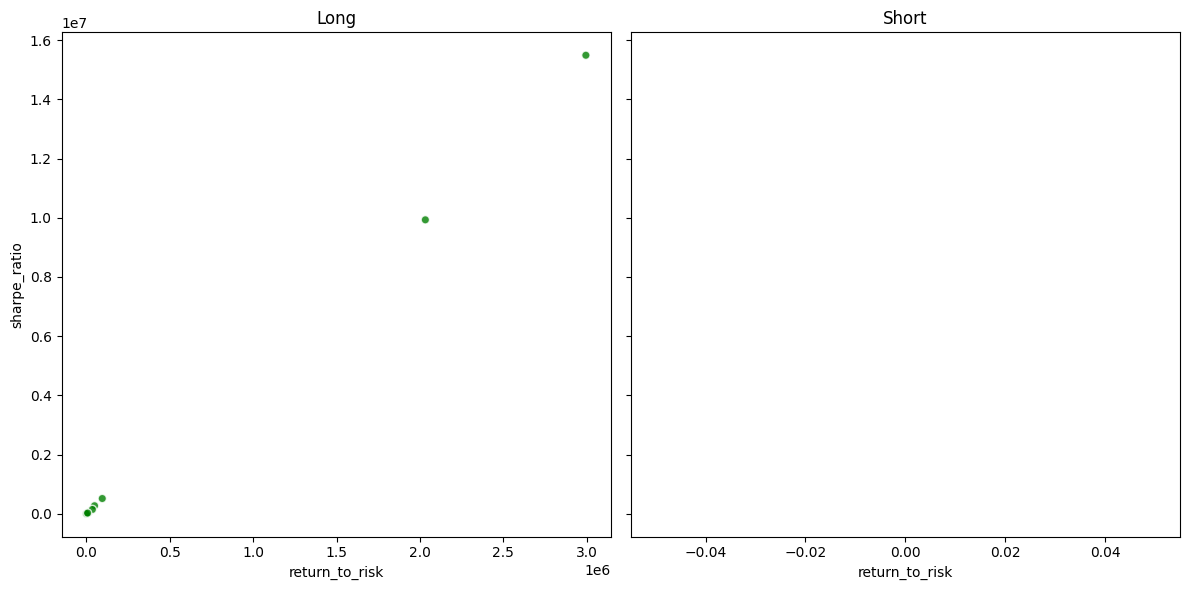

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [39]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

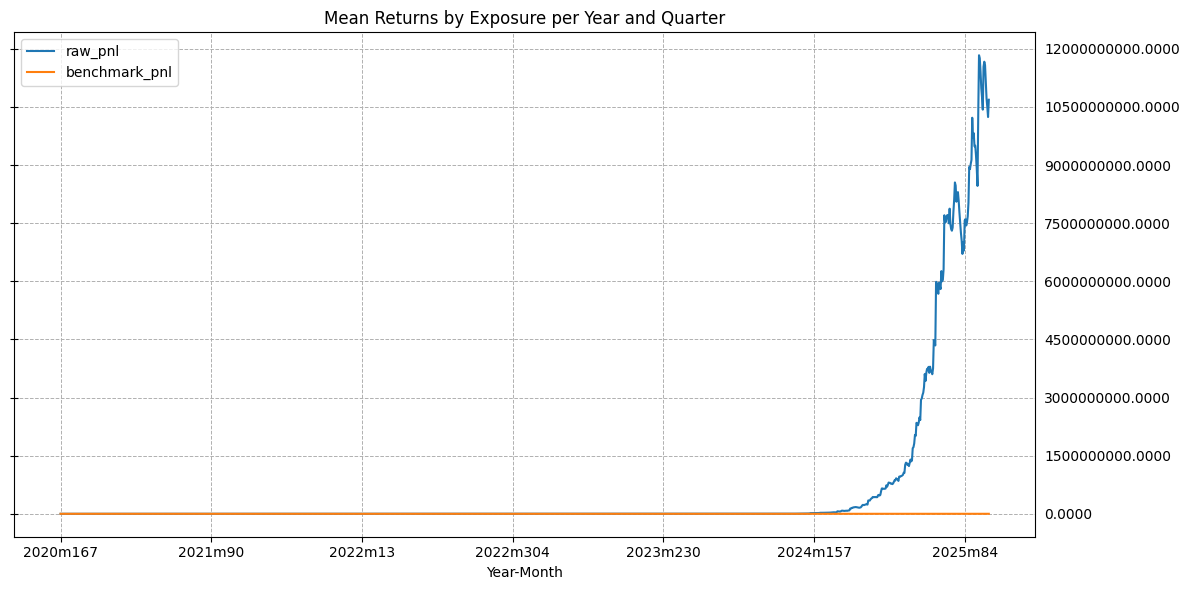

In [40]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio[pm.timeframe.value].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [41]:
trades[["group_percentile","return"]].groupby("group_percentile").mean().sort_values("return",ascending=False)

,return
group_percentile,
2,1.015646
3,1.015136
1,1.011657


In [42]:
portfolio.sort_values("date")

,index,year,day,date,weighted_return,return,pnl,raw_pnl,benchmark,benchmark_pnl,month,quarter,week,Year-Month
0,0,2020,167,2020-06-15 00:00:00+00:00,0.998328,0.998328,9.983276e-01,9.983276e-01,88.07,1.000000,6,2,25,2020m167
1,1,2020,168,2020-06-16 00:00:00+00:00,1.008706,1.008706,1.007019e+00,1.007019e+00,88.78,1.008062,6,2,25,2020m168
2,2,2020,169,2020-06-17 00:00:00+00:00,1.112011,1.112011,1.119816e+00,1.119816e+00,86.53,0.982514,6,2,25,2020m169
3,3,2020,170,2020-06-18 00:00:00+00:00,0.961519,0.961519,1.076724e+00,1.076724e+00,86.06,0.977177,6,2,25,2020m170
4,4,2020,171,2020-06-19 00:00:00+00:00,0.974078,0.974078,1.048814e+00,1.048814e+00,85.08,0.966050,6,2,25,2020m171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,1228,2025,125,2025-05-05 00:00:00+00:00,0.959722,0.959722,1.032753e+07,1.111169e+10,252.56,2.867719,5,2,19,2025m125
1229,1229,2025,126,2025-05-06 00:00:00+00:00,0.964021,0.964021,9.955956e+06,1.071191e+10,249.25,2.830135,5,2,19,2025m126
1230,1230,2025,127,2025-05-07 00:00:00+00:00,0.979924,0.979924,9.756082e+06,1.049686e+10,249.39,2.831725,5,2,19,2025m127
1231,1231,2025,128,2025-05-08 00:00:00+00:00,0.975325,0.975325,9.515348e+06,1.023784e+10,253.47,2.878052,5,2,19,2025m128


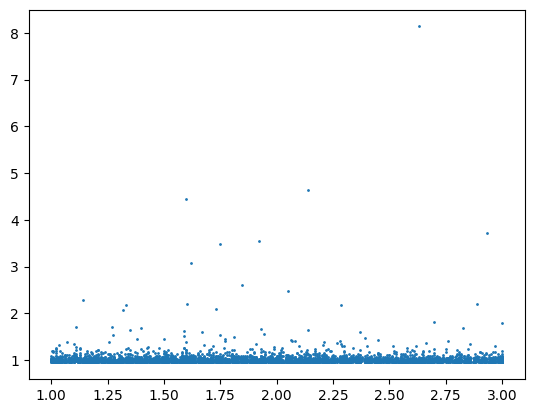

In [43]:
plt.scatter(trades["adjclose"],trades["weighted_return"],s=1)
plt.show()

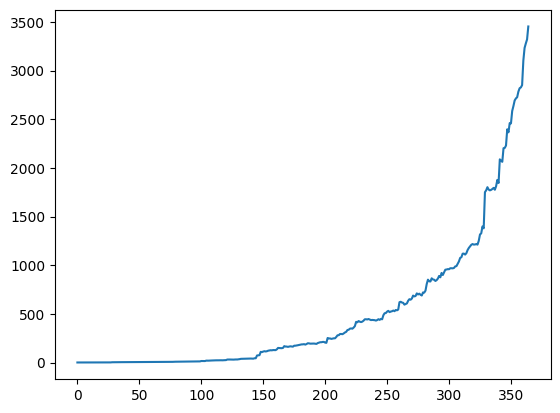

In [48]:
averaged_portfolio = portfolio.groupby("day").agg({"weighted_return":"mean","return":"mean"}).reset_index()
averaged_portfolio["pv"] = averaged_portfolio["weighted_return"].cumprod()
plt.plot(averaged_portfolio["pv"])
plt.show()

In [47]:
trades.tail(20)

,year,day,ticker,date,adjclose,sell_price,rolling_dollar_volume,sma,risk,group_percentile,...,position_type,weight,unweighted_return,stoploss_return,winsorized_return,weighted_return,return,month,quarter,week
548,2025,91,GRI,2025-04-01 00:00:00+00:00,2.02,1.670,2.834491e+05,0.957391,0.240012,2,...,1.0,1,0.826733,0.950000,0.950000,0.950000,0.950000,4,2,14
4183,2025,91,HYFM,2025-04-01 00:00:00+00:00,1.97,2.150,6.594271e+04,0.329101,0.197601,3,...,1.0,1,1.091371,1.091371,1.091371,1.091371,1.091371,4,2,14
251,2025,92,LPRO,2025-04-02 00:00:00+00:00,1.28,1.200,6.973557e+06,1.489316,0.294100,1,...,1.0,1,0.937500,0.950000,0.950000,0.950000,0.950000,4,2,14
774,2025,92,APVO,2025-04-02 00:00:00+00:00,1.38,1.990,2.597611e+05,0.788198,0.293436,2,...,1.0,1,1.442029,1.442029,1.442029,1.442029,1.442029,4,2,14
1166,2025,92,SBEV,2025-04-02 00:00:00+00:00,1.64,1.565,7.087994e+04,0.630238,0.460700,3,...,1.0,1,0.954268,0.954268,0.954268,0.954268,0.954268,4,2,14
116,2025,93,GRI,2025-04-03 00:00:00+00:00,1.44,1.510,3.127285e+06,2.180030,0.356605,1,...,1.0,1,1.048611,1.048611,1.048611,1.048611,1.048611,4,2,14
895,2025,93,XTIA,2025-04-03 00:00:00+00:00,1.12,1.100,8.267827e+05,0.722807,0.309522,2,...,1.0,1,0.982143,0.982143,0.982143,0.982143,0.982143,4,2,14
1560,2025,93,CRIS,2025-04-03 00:00:00+00:00,1.33,1.230,1.450137e+05,0.531757,0.201910,3,...,1.0,1,0.924812,0.950000,0.950000,0.950000,0.950000,4,2,14
67,2025,94,ALDX,2025-04-04 00:00:00+00:00,1.89,1.950,1.077223e+07,3.019014,0.259033,1,...,1.0,1,1.031746,1.031746,1.031746,1.031746,1.031746,4,2,14
1372,2025,94,CNSP,2025-04-04 00:00:00+00:00,1.10,1.120,7.248450e+05,0.573451,0.435172,2,...,1.0,1,1.018182,1.018182,1.018182,1.018182,1.018182,4,2,14
